# **CrossLabFit**: A Novel Framework for Integrating Qualitative and Quantitative Data Across Multiple Labs for Model Calibration
*Authors: Rodolfo Blanco-Rodriguez, Tanya A. Miura, Esteban Hernandez-Vargas*

**CrossLabFit** is a modeling framework designed to enhance parameter estimation in complex biological models by integrating both **quantitative datasets** and **qualitative knowledge** (e.g., expected behavior, constraints, or expert-derived "windows"). This hybrid approach improves identifiability and interpretability, especially in systems where data is sparse or noisy.

The core idea is to embed both **constraints** and **window constraints** into the cost function during optimization, allowing the search space to be shaped by both observed data and known system behavior.

---

## Notebook Overview

This notebook provides a complete walkthrough of the CrossLabFit pipeline:

1. **Model Definition**
2. **Data Import**
3. **Definition of Window Constraints**
4. **Modified Cost Function**
5. **Optimization**
6. **Profile likelihoods**
7. **Bootstrapping**

> Developed and maintained by *Rodolfo Blanco-Rodriguez* – July 2025  
> For more info or citation, please contact: *Esteban Hernandez-Vargas* – esteban@uidaho.edu

---

## 0. Importing Essential Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.cluster import KMeans
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.integrate import ODEintWarning
from scipy.optimize import differential_evolution
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

viridis_pal = sns.color_palette('viridis', n_colors=8)
rocket_pal = sns.color_palette('rocket', n_colors=3)

## 1. Model Definition

We consider a three-species **cyclic Lotka-Volterra model**, often used to describe predator-prey-like interactions with non-transitive dynamics. The system is defined by the following set of ordinary differential equations:

\begin{align}
\dot{X}_1 &= - a_1 X_1 - a_2 X_1 X_2 + a_3 X_1 X_3 \\
\dot{X}_2 &= \phantom{-} a_4 X_1 X_2 - a_5 X_2 - a_6 X_2 X_3 \\
\dot{X}_3 &= - a_7 X_1 X_3 + a_8 X_2 X_3 - a_9 X_3
\end{align}

where:
- $X_1(t), X_2(t), X_3(t)$ represent the abundances (or concentrations) of three interacting populations over time,
- $a_1, \dots, a_9$ are positive model parameters governing growth, decay, and interaction rates,
- $\dot{X}_i = dX_i/dt$ denotes the time derivative of $X_i$.

This system exhibits cyclic dominance and oscillatory behavior under certain parameter regimes, making it a good testbed for the **CrossLabFit** parameter estimation framework.

In [2]:
def modelLV(X, t, params):
    a1, a2, a3, a4, a5, a6, a7, a8, a9 = params
    X1, X2, X3 = X

    # Prevent negative or huge values
    X1 = np.clip(X1, 0, 1e6)
    X2 = np.clip(X2, 0, 1e6)
    X3 = np.clip(X3, 0, 1e6)
    
    dX1 = - a1*X1 - a2*X1*X2 + a3*X1*X3
    dX2 = a4*X1*X2 - a5*X2 - a6*X2*X3
    dX3 = -a7*X1*X3 + a8*X2*X3 - a9*X3
    
    return [dX1, dX2, dX3]

### 1.1. Ground Truth Solution

For validation and comparison purposes, we define a reference set of **ground truth parameters** selected arbitrarily. These values are considered the "true" parameters that the model fitting procedure attempts to recover using synthetic data. These values were also used to generate the synthetic data.

In [3]:
# Ground truth values
a1 = 0.18
a2 = 0.16 
a3 = 0.15 
a4 = 0.11 
a5 = 0.02 
a6 = 0.12 
a7 = 0.04 
a8 = 0.12 
a9 = 0.02

groundParams = np.array([a1, a2, a3, a4, a5, a6, a7, a8, a9])

We assume that the initial conditions are known. Therefore, we generate the **ground truth solution**.

In [4]:
# Initial conditions
X0 = [4, 2, 1]

t = np.linspace(0, 80, 161)

sol = odeint(modelLV, X0, t, args=(groundParams,))

X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

## 2. Data Import

In this example, we work with **synthetic data** generated from the ground truth solution of the cyclic Lotka-Volterra model.

The procedure for generating the synthetic dataset is as follows:

- The model was simulated using the ground truth parameters.
- Time series data was recorded for the variable $X_1(t)$ at regular time intervals.
- To simulate experimental variability, we generated **five replicates** by adding **log-normal noise** to the true $X_1(t)$ values:
  
$$X_{1}^{\text{obs}}(t) = X_{1}^{\text{true}}(t) \exp\left( \epsilon \right), \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

  where $\sigma$ is the standard deviation of the logarithmic noise.

The **same procedure** was applied to variable $X_3(t)$, generating additional datasets with varying noise levels and sampling frequencies. The code used to generate these datasets can be found in the "Miscellaneous" folder of the GitHub repository.

**Dataset Overview**

- **Dataset A**: Synthetic measurements of $X_1$, consisting of 5 log-normal replicates. This dataset is used for **quantitative model fitting** by minimizing the residual sum of squares (RSS).

- **Datasets B1–B4**: Synthetic measurements of $X_3$, each representing different sampling schemes and noise levels. These datasets are **not used directly for fitting**, but serve to define **window constraints** that guide the optimization process in the CrossLabFit framework.

*Note: Dataset A informs the cost function quantitatively, while Datasets B1–B4 contribute indirectly by shaping the feasible parameter space through qualitative behavior constraints.*

In [5]:
# Dataset A
dfData_A = pd.read_csv('data/LVdata_X1noise.csv')

# Dataset B1-B4
dfData_B1 = pd.read_csv('data/LVdata_X3noise_1.csv')
dfData_B2 = pd.read_csv('data/LVdata_X3noise_2.csv')
dfData_B3 = pd.read_csv('data/LVdata_X3noise_3.csv')
dfData_B4 = pd.read_csv('data/LVdata_X3noise_4.csv')

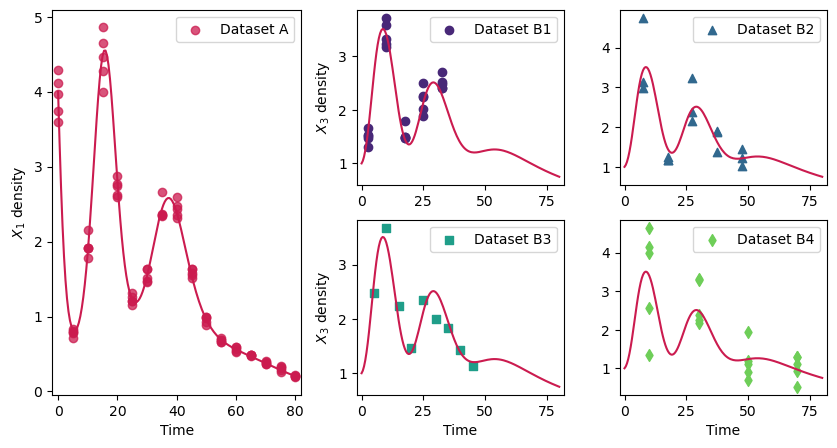

In [6]:
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 3, width_ratios=[1.2, 1, 1], wspace=0.25, hspace=0.2)

t = np.linspace(0, 80, 161)

# Dataset A
ax_A = fig.add_subplot(gs[:, 0])
ax_A.scatter(dfData_A['Time'], dfData_A['X1'], color=rocket_pal[1], marker="o", alpha=0.75, label='Dataset A')
ax_A.plot(t, X1_g, color=rocket_pal[1])
ax_A.set_ylabel('$X_1$ density')
ax_A.set_xlabel('Time')
ax_A.set_xlim(-2, 82)
ax_A.legend()

# Dataset B1
ax_B1 = fig.add_subplot(gs[0, 1])
ax_B1.scatter(dfData_B1['Time'], dfData_B1['X3'], color=viridis_pal[0], marker="o", label='Dataset B1')
ax_B1.plot(t, X3_g, color=rocket_pal[1])
ax_B1.set_ylabel('$X_3$ density')

# Dataset B2
ax_B2 = fig.add_subplot(gs[0, 2])
ax_B2.scatter(dfData_B2['Time'], dfData_B2['X3'], color=viridis_pal[2], marker="^", label='Dataset B2')
ax_B2.plot(t, X3_g, color=rocket_pal[1])

# Dataset B3
ax_B3 = fig.add_subplot(gs[1, 1])
ax_B3.scatter(dfData_B3['Time'], dfData_B3['X3'], color=viridis_pal[4], marker="s", label='Dataset B3')
ax_B3.plot(t, X3_g, color=rocket_pal[1])
ax_B3.set_xlabel('Time')
ax_B3.set_ylabel('$X_3$ density')

# Dataset B4
ax_B4 = fig.add_subplot(gs[1, 2])
ax_B4.scatter(dfData_B4['Time'], dfData_B4['X3'], color=viridis_pal[6], marker="d", label='Dataset B4')
ax_B4.plot(t, X3_g, color=rocket_pal[1])
ax_B4.set_xlabel('Time')

# Limits and legends
for ax in [ax_B1, ax_B2, ax_B3, ax_B4]:
    ax.set_xlim(-2, 82)
    ax.legend()

plt.show()

## 3. Definition of Window Constraints

To enhance parameter identifiability, the CrossLabFit framework incorporates **window constraints** derived from auxiliary data, specifically, **Datasets B1–B4**. The window constraints are constructed through the following steps:

### 3.1. Normalization
Each $X_3$ dataset is normalized prior to clustering.

*Note: In this example, normalization is not strictly necessary since all datasets share the same scale. However, we include it to illustrate the general pipeline, as in practice Datasets B may originate from different sources or experimental settings with slight scale mismatches.*

In [7]:
# Apply Min-Max normalization
minVal = dfData_B1['X3'].min()
maxVal = dfData_B1['X3'].max()
dfData_B1['X3_norm'] = (dfData_B1['X3'] - minVal) / (maxVal - minVal)

minVal = dfData_B2['X3'].min()
maxVal = dfData_B2['X3'].max()
dfData_B2['X3_norm'] = (dfData_B2['X3'] - minVal) / (maxVal - minVal)

minVal = dfData_B3['X3'].min()
maxVal = dfData_B3['X3'].max()
dfData_B3['X3_norm'] = (dfData_B3['X3'] - minVal) / (maxVal - minVal)

minVal = dfData_B4['X3'].min()
maxVal = dfData_B4['X3'].max()
dfData_B4['X3_norm'] = (dfData_B4['X3'] - minVal) / (maxVal - minVal)

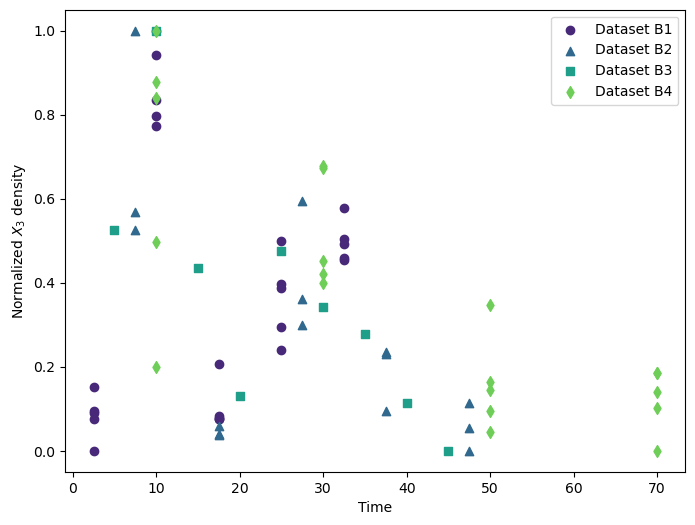

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

ax.scatter(dfData_B1['Time'], dfData_B1['X3_norm'],
            color=viridis_pal[0], label='Dataset B1', marker='o')
ax.scatter(dfData_B2['Time'], dfData_B2['X3_norm'],
            color=viridis_pal[2], label='Dataset B2', marker='^')
ax.scatter(dfData_B3['Time'], dfData_B3['X3_norm'],
            color=viridis_pal[4], label='Dataset B3', marker='s')
ax.scatter(dfData_B4['Time'], dfData_B4['X3_norm'],
            color=viridis_pal[6], label='Dataset B4', marker='d')

ax.set_xlabel('Time')
ax.set_ylabel('Normalized $X_3$ density')
ax.legend()

plt.show()

In [9]:
dfData_B = pd.concat([dfData_B1[['Time', 'X3_norm']], dfData_B2[['Time', 'X3_norm']],
                        dfData_B3[['Time', 'X3_norm']], dfData_B4[['Time', 'X3_norm']]])
dfData_B = dfData_B.sort_values(by='Time').reset_index(drop=True)

### 3.2. Clustering
Clustering is performed independently along the **time axis** and the **normalized $X_3$ axis** using unsupervised methods (e.g., KMeans). The optimal number of clusters is determined via internal validation metrics (e.g., elbow method).

#### 3.2.1. Temporal axis

In [10]:
# Elbow Method to determine the optimal number of clusters for Time
inertia = []
k_range = range(1, 11)

Xdata = dfData_B[['Time']].values

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(Xdata)
    inertia.append(kmeans.inertia_)

diff = np.diff(inertia)
diff_r = diff[1:] / diff[:-1]
optimal_k = k_range[np.argmin(diff_r) + 1]

In [11]:
# Store the inertia and the optimal number of clusters. The latter can be chosen manually
inertia_time = inertia
optK_time = optimal_k

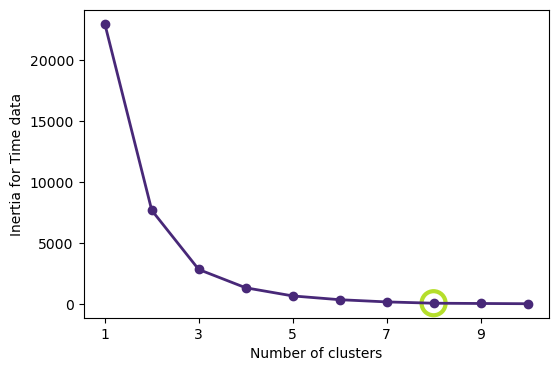

In [12]:
# Plot the elbow method
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia_time, marker='o', color=viridis_pal[0], lw = 2)
plt.scatter(optK_time, inertia_time[optK_time - 1],
            s=300, facecolors='none', edgecolors=viridis_pal[7], lw = 3)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia for Time data')
plt.xticks([1,3,5,7,9])

plt.show()

In [13]:
# Store labels
kmeans = KMeans(n_clusters=optK_time, n_init=10)
kmeans.fit(Xdata)
dfData_B['Time labels'] = kmeans.labels_

#### 3.2.2. Variable axis

In [14]:
# Elbow Method to determine the optimal number of clusters for X3
inertia = []
k_range = range(1, 11)  # Test for k from 1 to 10

Xdata = dfData_B[['X3_norm']].values

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(Xdata)
    inertia.append(kmeans.inertia_)

diff = np.diff(inertia)
diff_r = diff[1:] / diff[:-1]
optimal_k = k_range[np.argmin(diff_r) + 1]

In [15]:
# Store the inertia and the optimal number of clusters. The latter can be chosen manually
inertia_X3 = inertia
optK_X3 = optimal_k

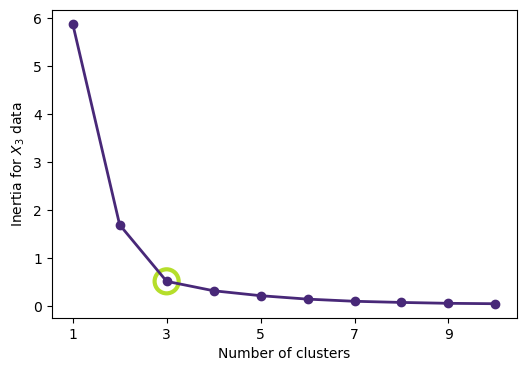

In [16]:
# Plot the elbow method
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia_X3, marker='o', color=viridis_pal[0], lw = 2)
plt.scatter(optK_X3, inertia_X3[optK_X3 - 1],
            s=300, facecolors='none', edgecolors=viridis_pal[7], lw = 3)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia for $X_3$ data')
plt.xticks([1,3,5,7,9])

plt.show()

In [17]:
kmeans = KMeans(n_clusters=optK_X3, n_init=10)
kmeans.fit(Xdata)
dfData_B['X3 labels'] = kmeans.labels_

### 3.3. Grid Mesh Construction
Using the optimal clusters on both axes, we construct a 2D grid (time $\times$ normalized $X_3$) partitioning the observation space.

In [18]:
# Obtaining the mesh
xMin = []
xMax = []
unique_time_labels = sorted(dfData_B['Time labels'].unique())
for label in unique_time_labels:
    x = dfData_B[dfData_B['Time labels'] == label]['Time']
    xMin.append(x.min())
    xMax.append(x.max())
xMin.sort()
xMax.sort()

xCell = [xMin[0] - (xMin[1]-xMax[0])/2]
for i in range(len(xMin)-1):
    xCell.append((xMax[i]+xMin[i+1])/2)
xCell.append(xMax[-1] + xMin[-1] - xCell[-1])

# Adding horizontal lines for CD8 labels
yMin = []
yMax = []
unique_x3_labels = sorted(dfData_B['X3 labels'].unique())
for label in unique_x3_labels:
    y = dfData_B[dfData_B['X3 labels'] == label]['X3_norm']
    yMin.append(y.min())
    yMax.append(y.max())
yMin.sort()
yMax.sort()

yCell = [yMin[0]]
for i in range(len(yMin)-1):
    yCell.append((yMax[i]+yMin[i+1])/2)
yCell.append(yMax[-1])

### 3.4. Window Selection
For each time-based cluster (i.e., each column of the grid), we identify the cell (row) with the **highest density of points**, indicating the most probable range of $X_3$ at that time. This results in a time-resolved sequence of intervals defining the **window constraints**.

In [19]:
# Use numpy histogram2d to count occurrences in each cell
cellCounts, _, _ = np.histogram2d(dfData_B['Time'], dfData_B['X3_norm'], bins=[xCell, yCell])

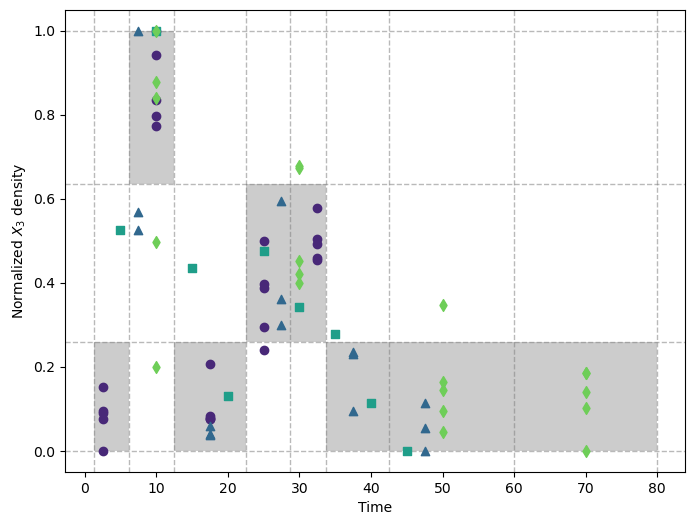

In [20]:
# Plotting the mesh
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

ax.scatter(dfData_B1['Time'], dfData_B1['X3_norm'],
            color=viridis_pal[0], label='Dataset 1', marker='o')
ax.scatter(dfData_B2['Time'], dfData_B2['X3_norm'],
            color=viridis_pal[2], label='Dataset 2', marker='^')
ax.scatter(dfData_B3['Time'], dfData_B3['X3_norm'],
            color=viridis_pal[4], label='Dataset 3', marker='s')
ax.scatter(dfData_B4['Time'], dfData_B4['X3_norm'],
            color=viridis_pal[6], label='Dataset 4', marker='d')

# Adding vertical lines for Time labels
for i in range(len(xCell)):
    ax.axvline(x=xCell[i], color='gray', linestyle='--', alpha = 0.55, zorder=0, lw=1)

# Adding horizontal lines for X3 labels
for i in range(len(yCell)):
    ax.axhline(y=yCell[i], color='gray', linestyle='--', alpha = 0.55, zorder=0, lw=1)

# Add squares (window constraints)
windows = []
xDiff = np.diff(xCell)
yDiff = np.diff(yCell)
for i in range(cellCounts.shape[0]):
    j = cellCounts[i].argmax()
    rect = plt.Rectangle((xCell[i], yCell[j]), xDiff[i], yDiff[j], fc='gray', alpha = 0.4, zorder=-1)
    ax.add_patch(rect)
    windows.append([xCell[i], xCell[i+1], yCell[j], yCell[j+1]])

ax.set_xlabel('Time')
ax.set_ylabel('Normalized $X_3$ density')

plt.show()

In [21]:
dfWindows = pd.DataFrame(windows, columns=['Tmin', 'Tmax', 'X3min', 'X3max'])
dfWindows

,Tmin,Tmax,X3min,X3max
0,1.25,6.25,0.000000,0.259050
1,6.25,12.50,0.634149,1.000000
2,12.50,22.50,0.000000,0.259050
3,22.50,28.75,0.259050,0.634149
4,28.75,33.75,0.259050,0.634149
5,33.75,42.50,0.000000,0.259050
6,42.50,60.00,0.000000,0.259050
7,60.00,80.00,0.000000,0.259050


### 3.5. Rescaling
The selected windows (defined in normalized coordinates) are rescaled back to the original $X_3$ range.

*Note: In this example, the rescaling is based on the minimum and maximum of the ground truth trajectory. However, in practical applications where such information is not available a priori, the rescaling should instead rely on a plausible expected range, informed by prior knowledge or experimental context.*

In [22]:
# X3_0 = X3_g.min()
X3_0 = 1
scale = X3_g.max() - X3_0
ref = X3_0 - 0.05*scale # We start 5% before the minimum
dfWindows['X3min'] = 1.1*scale*dfWindows['X3min'] + ref # Finish 5% after the maximum
dfWindows['X3max'] = 1.1*scale*dfWindows['X3max'] + ref # Finish 5% after the maximum

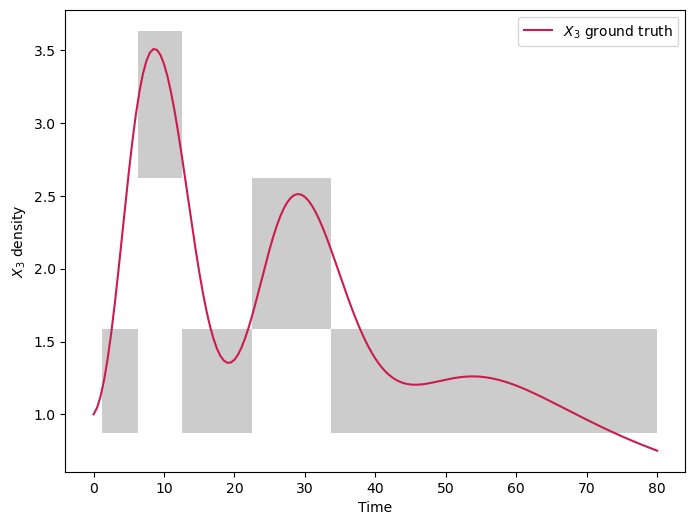

In [23]:
# Plotting results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

ax.plot(t, X3_g, lw=1.5, color=rocket_pal[1], label='$X_3$ ground truth')

# Add squares (qualitative windows)
Tmin = dfWindows['Tmin']
Tdiff = dfWindows['Tmax'] - dfWindows['Tmin']

X3min = dfWindows['X3min']
X3diff = dfWindows['X3max'] - dfWindows['X3min']

for a, b, w, h in zip(Tmin, X3min, Tdiff, X3diff):
    rect = plt.Rectangle((a, b), w, h, fc='gray', alpha = 0.4, zorder=-1)
    ax.add_patch(rect)

ax.set_xlabel('Time')
ax.set_ylabel('$X_3$ density')
ax.legend()

plt.show()

## 4. Modified Cost Function

In CrossLabFit, the parameter estimation process is guided by a **modified cost function** that combines both **quantitative error** (from Dataset A) and **qualitative window constraints** (from Datasets B1–B4).

The total cost function is defined as function of the parameter vector $\vec a$:
$$J(\vec a) = J_\text{qt}(\vec a) + J_\text{ql}(\vec a)$$
where $J_\text{qt}$ is the traditional **residual sum of squares** computed between the model output $X_1(t)$ and the observations $\bar X_1(t)$ in **Dataset A**, given by:
$$J_{\text{qt}}(\vec a) = \text{RSS}(\vec a) = \sum_i \left(\bar X_1(t_i) - X_1(\vec a; t_i) \right)^2$$
while $J_{\text{ql}}$ is a **binary penalty term** that report the violation of **window constraints** on $X_3(t)$. The penalty term is defined as:

$$J_\text{ql}(\vec a) = \left \{ \begin{array}{ll}
        0 &\ \text{if }X_3(\vec a; t) \text{ cross all windows constraints}\\
        M &\ \text{otherwise, where } M \gg J_\text{qt}(\vec a) \\
    \end{array} \right.$$

where $M$ is an arbitrary number large enough to penalize the cost function.

*Note: In this Python version, the penalty $M$ is multiplied by a random number sampled uniformly in each evaluation. This stochastic penalty multiplier is introduced as a practical artifact to allow the Differential Evolution to explore the parameter space when all initial candidates violate the window constraints. This could have been avoided by using a continuous soft penalty formulation. However, we kept this approach to compare it with our in-house code implementation.*


In [24]:
def compute_rss(data_A, interp_func):
    try:
        times = data_A[:, 0]
        obs = data_A[:, 1]

        # Find unique times and how many replicates there are per time
        unique_times, counts = np.unique(times, return_counts=True)

        # Interpolate model at unique time points
        model_values = interp_func(unique_times)

        # Repeat to match number of replicates
        model_repeated = np.repeat(model_values, counts)

        diff = obs - model_repeated
        if not np.all(np.isfinite(diff)):
            return 1e6

        rss = np.sum(diff ** 2)
        if not np.isfinite(rss):
            return 1e6
        
        return rss

    except Exception:
        return 1e6

In [25]:
def cost_function(params, model_func, data_A, windows=None, use_windows=True,
                  num_variables=3, rss_variable=0, window_variable=2, penalty_value=1e6):
    try:
        # Separate parameters and initial conditions
        param_vec = params[:-num_variables]
        X0 = params[-num_variables:]

        # Time range
        t_max_A = np.max(data_A[:, 0])
        if use_windows and windows is not None:
            t_max = max(t_max_A, np.max(windows[:, 1]))
        else:
            t_max = t_max_A

        t_eval = np.linspace(0, t_max, 1000)

        # Solve ODE model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ODEintWarning)
            sol = odeint(model_func, X0, t_eval, args=(param_vec,))

        if not np.all(np.isfinite(sol)):
            return penalty_value * np.random.uniform(1, 2)

        # Window constraint check
        if use_windows and windows is not None:
            var_w = sol[:, window_variable]
            for row in windows:
                tmin, tmax, vmin, vmax = row
                mask = (t_eval >= tmin) & (t_eval <= tmax)
                if not np.any((var_w[mask] >= vmin) & (var_w[mask] <= vmax)):
                    return penalty_value * np.random.uniform(1, 2)

        # RSS computation
        var_rss = sol[:, rss_variable]
        interp_func = interp1d(t_eval, var_rss, kind='linear', bounds_error=False, fill_value='extrapolate')
        return compute_rss(data_A, interp_func)

    except Exception:
        return penalty_value * np.random.uniform(1, 2)

## 5. Optimization

To estimate the model parameters, we use **Differential Evolution (DE)** — a global optimization algorithm suitable for complex, non-convex search spaces.

In our original implementation, we developed a **custom DE algorithm in CUDA/C**, optimized for large-scale, parallel evaluations. This implementation is highly efficient but must be **manually modified** to accommodate different models, making it less flexible for general use. The CUDA/C source code is available in the `cudaDE/` folder of this project.

### 5.1. Python DE for Notebook Integration

In this notebook, we instead use the **`scipy.optimize.differential_evolution`** function to:

1. Provide a **self-contained** and reproducible implementation within a single notebook.
2. Allow for a **more flexible and accessible** setup to test different case studies and models.
3. Enable a **comparative analysis** between a widely used DE library and our custom parallel version.

The optimization minimizes the cost function defined earlier, which combines the residual sum of squares (RSS) and qualitative penalties derived from window constraints.

In [26]:
# Define parameter bounds in the specified order
bounds = [
    (5e-2, 5e-1),  # a1
    (5e-2, 5e-1),  # a2
    (5e-2, 5e-1),  # a3
    (5e-2, 5e-1),  # a4
    (1e-2, 1e-1),  # a5
    (5e-2, 5e-1),  # a6
    (1e-2, 1e-1),  # a7
    (5e-2, 5e-1),  # a8
    (1e-2, 1e-1),  # a9
]
# Initial conditions are defined as parameters
# The same bounds mean that the parameter will have a fixed value
bounds += [
    (4.0, 4.0),  # X1_0
    (2.0, 2.0),  # X2_0
    (1.0, 1.0),  # X3_0
]

In [27]:
%%time

objective = partial(
    cost_function,
    model_func=modelLV,
    data_A=dfData_A.values,
    windows=dfWindows.values,
    use_windows=True,
    num_variables=3,
    rss_variable=0, # X1
    window_variable=2, # X3
    penalty_value=1e6
)

result = differential_evolution(
    func=objective, 
    bounds=bounds,
    strategy='rand1bin',
    maxiter=5,
    popsize=20,
    tol=1e-6,
    mutation=0.8,
    recombination=0.8,
    polish=True,
    workers=-1,  # parallel execution
    updating='deferred',
    seed=42,
    disp=True
)

num_variables = 3
X0 = result.x[-num_variables:]
bestParams = result.x[:-num_variables]
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

differential_evolution step 1: f(x)= 1043309.8129662761
differential_evolution step 2: f(x)= 1004166.827443556
differential_evolution step 3: f(x)= 1004166.827443556
differential_evolution step 4: f(x)= 1004166.827443556
differential_evolution step 5: f(x)= 1004166.827443556
Polishing solution with 'L-BFGS-B'
Optimized parameters: [0.1118221  0.37525581 0.46985252 0.40771244 0.07740302 0.46539619
 0.0818487  0.41915994 0.01590369]
Final cost: 1004166.827443556
CPU times: user 177 ms, sys: 118 ms, total: 295 ms
Wall time: 3.77 s


> *Note: The previous cell runs the optimization process directly. However, for a cleaner and more modular approach, it's better to define the optimization as a standalone function. Unfortunately, defining the objective function locally inside another function (as is common in notebooks) is incompatible with parallel execution using `workers=-1` in `differential_evolution`.
To overcome this and enable efficient parallel optimization—especially for tasks like profile likelihoods and bootstrapping, which require repeated runs—we move the necessary functions into a separate Python file. This allows the optimization to run safely and efficiently with parallelism enabled.*

In [28]:
from run_optimization import run_DE

In [29]:
# Run optimizer without windows constraints
result = run_DE(
    bounds=bounds,
    model_func=modelLV,
    data_A=dfData_A.values,
    windows=dfWindows.values,
    use_windows=False,
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6,
    maxiter=50,
    popsize=20,
    disp=False
)

num_variables = 3
X0 = result.x[-num_variables:]
bestParams = result.x[:-num_variables]
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_noWin = bestParams

Optimized parameters: [0.11068263 0.29952692 0.24611288 0.12278877 0.05602171 0.18737843
 0.01586114 0.10408341 0.04915706]
Final cost: 1.141320985281733


In [30]:
# Run optimizer with windows constraints
result = run_DE(
    bounds=bounds,
    model_func=modelLV,
    data_A=dfData_A.values,
    windows=dfWindows.values,
    use_windows=True,
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6,
    maxiter=50,
    popsize=20,
    disp=False
)

num_variables = 3
X0 = result.x[-num_variables:]
bestParams = result.x[:-num_variables]
cost = result.fun

print("Optimized parameters:", bestParams)
print("Final cost:", cost)

bestParams_win = bestParams

Optimized parameters: [0.20604155 0.35575218 0.12600143 0.284279   0.08696957 0.07317085
 0.0285823  0.19217349 0.02519864]
Final cost: 1002510.3052919317


In [31]:
# Solve model using optimized parameters
t = np.linspace(0, 80, 161)

solution = odeint(modelLV, X0, t, args=(bestParams_noWin,))
X1_noWin, X2_noWin, X3_noWin = solution.T

solution = odeint(modelLV, X0, t, args=(bestParams_win,))
X1_win, X2_win, X3_win = solution.T

/tmp/ipykernel_48217/1662835528.py:7: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(modelLV, X0, t, args=(bestParams_win,))


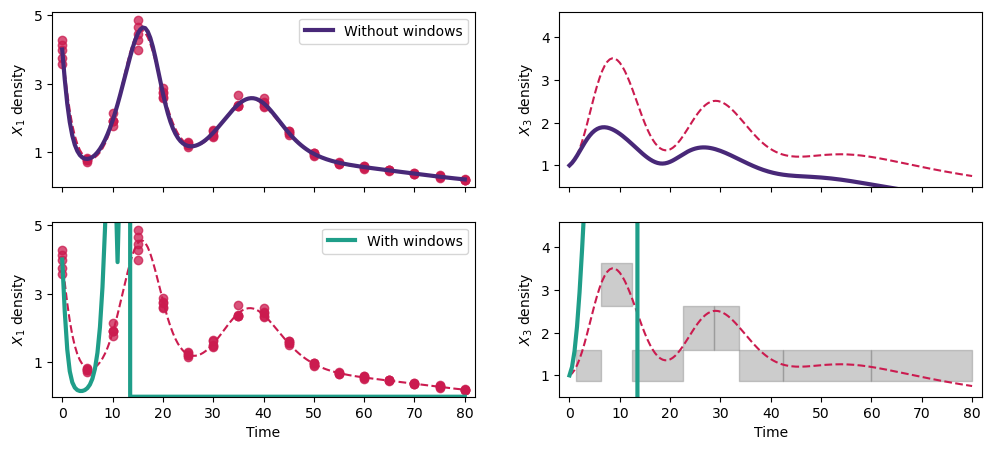

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,5), sharex=True)

ax[0,0].scatter(x=dfData_A['Time'], y=dfData_A['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[0,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[0,0].plot(t, X1_noWin, lw=3, color=viridis_pal[0], label='Without windows')
ax[0,0].legend()

ax[0,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[0,1].plot(t, X3_noWin, lw=3, color=viridis_pal[0])

ax[1,0].scatter(x=dfData_A['Time'], y=dfData_A['X1'], color=rocket_pal[1], marker="o", alpha=0.75)
ax[1,0].plot(t, X1_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[1,0].plot(t, X1_win, lw=3, color=viridis_pal[4], label='With windows')
ax[1,0].legend()

ax[1,1].plot(t, X3_g, lw=1.5, color=rocket_pal[1], ls='--')
ax[1,1].plot(t, X3_win, lw=3, color=viridis_pal[4])

# Overlay window constraints
for _, row in dfWindows.iterrows():
    tmin, tmax = row['Tmin'], row['Tmax']
    x3min, x3max = row['X3min'], row['X3max']
    ax[1,1].fill_betweenx(
        [x3min, x3max], tmin, tmax, color='gray', alpha=0.4, label='Window' if _ == 0 else None
    )

ax[0,0].set_ylabel('$X_1$ density')
ax[0,1].set_ylabel('$X_3$ density')

ax[1,0].set_ylabel('$X_1$ density')
ax[1,1].set_ylabel('$X_3$ density')

ax[1,0].set_xlabel('Time')
ax[1,1].set_xlabel('Time')

for i in range(2):
    ax[i,0].set_ylim((0.0,5.1))
    ax[i,1].set_ylim((0.5,4.6))
    ax[i,0].set_yticks(np.arange(1, 6, 2))
    ax[i,1].set_yticks(np.arange(1, 5, 1))

plt.setp(ax, xlim=(-2,82))

plt.show()

## 6. Profile Likelihoods

To assess parameter identifiability and explore the confidence intervals around the estimated parameters, we compute **profile likelihoods**. This technique consists of:

1. **Fixing one parameter** at a set of values over a specified range.
2. **Re-optimizing** the remaining parameters to minimize the cost function at each fixed value.
3. **Recording the resulting cost** at each point to construct a likelihood profile.

This procedure allows us to visualize how sensitive the cost function is to changes in a given parameter, while accounting for the optimal adjustment of the others. Steep and narrow profiles suggest **high identifiability**, whereas flat or wide profiles may indicate **sloppy or non-identifiable parameters**.

In [36]:
from run_optimization import run_profile_likelihood

In [37]:
# without windows constraints
param_index = 2  # e.g., a3 is 2
param_range = (0.025, 0.275)  # range to explore
steps = 5  # resolution of the profile

# Compute profile likelihood
x_vals, y_costs = run_profile_likelihood(
    param_index=param_index,
    param_range=param_range,
    steps=steps,
    bounds=bounds,
    model_func=modelLV,
    data_A=dfData_A.values,
    windows=dfWindows.values,
    use_windows=False,
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6,
    maxiter=50,
    popsize=20
)

profile_noWin = np.column_stack([x_vals, y_costs])

[1/5] Fixed param 3 at 0.0250 → Cost: 1.9571
[2/5] Fixed param 3 at 0.0875 → Cost: 1.1738
[3/5] Fixed param 3 at 0.1500 → Cost: 8.4142
[4/5] Fixed param 3 at 0.2125 → Cost: 1.1394
[5/5] Fixed param 3 at 0.2750 → Cost: 1.1443


In [38]:
# with windows constraints
param_index = 2  # e.g., a3 is 2
param_range = (0.025, 0.275)  # range to explore
steps = 5  # resolution of the profile

# Compute profile likelihood
x_vals, y_costs = run_profile_likelihood(
    param_index=param_index,
    param_range=param_range,
    steps=steps,
    bounds=bounds,
    model_func=modelLV,
    data_A=dfData_A.values,
    windows=dfWindows.values,
    use_windows=True,
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6,
    maxiter=50,
    popsize=20
)

profile_win = np.column_stack([x_vals, y_costs])

[1/5] Fixed param 3 at 0.0250 → Cost: 1005668.4675
[2/5] Fixed param 3 at 0.0875 → Cost: 20.6823
[3/5] Fixed param 3 at 0.1500 → Cost: 1010111.1598
[4/5] Fixed param 3 at 0.2125 → Cost: 79.1395
[5/5] Fixed param 3 at 0.2750 → Cost: 110.9256


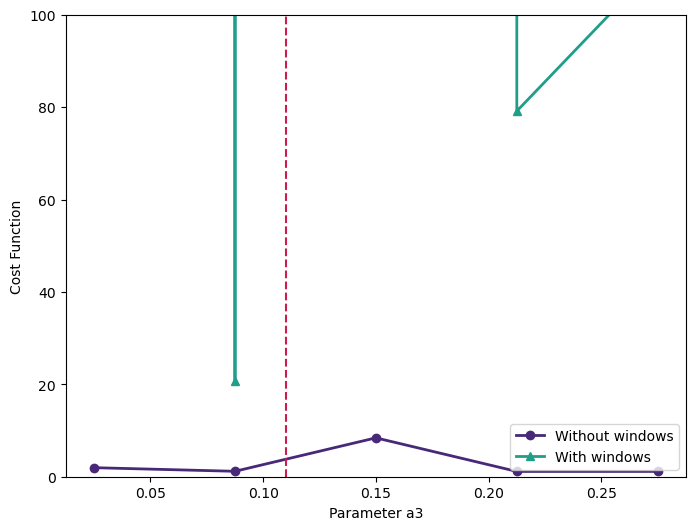

In [41]:
# Plotting results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

ax.plot(profile_noWin[:,0],profile_noWin[:,1], lw=2, marker='o', color=viridis_pal[0], label='Without windows')
ax.plot(profile_win[:,0],profile_win[:,1], lw=2, marker='^', color=viridis_pal[4], label='With windows')

ymax = 100
ax.vlines(groundParams[param_index+1], ymin=0.0, ymax=ymax, colors=rocket_pal[1], linestyles='dashed')
ax.set_ylim((0,ymax))
ax.set_xlabel(f'Parameter a{param_index+1}')
ax.set_ylabel('Cost Function')
ax.legend()

plt.show()

## 7. Bootstrapping

To assess the uncertainty and variability of the estimated parameters, we use a **bootstrapping approach**. The main idea is to resample the experimental dataset with replacement (creating multiple synthetic replicates of the original data) and re-run the **optimization process** on each resampled dataset.

The bootstrapping workflow is as follows:  

1. **Original dataset**: Start with the fitted Dataset.  
2. **Resampling**: Create `B` bootstrap samples by randomly sampling the data with replacement, preserving the original number of observations.  
3. **Optimization**: For each bootstrap sample, run the optimization procedure to obtain a new parameter estimate.  
4. **Parameter distribution**: Collect all bootstrap estimates and analyze their empirical distribution (e.g., mean, standard deviation, and percentiles).

In [42]:
from run_optimization import run_bootstrap

In [43]:
# without windows constraints
n_bootstrap = 5  

bootstrap_results = run_bootstrap(
    n_bootstrap=n_bootstrap,
    bounds=bounds,
    model_func=modelLV,
    data_A=dfData_A.values,
    windows=dfWindows.values,
    use_windows=False,
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6,
    maxiter=50,
    popsize=20
)

# Save to CSV for later analysis
df_bootstrap_noWin = pd.DataFrame(bootstrap_results, columns=[f"a{i+1}" for i in range(bootstrap_results.shape[1])])

[Bootstrap 1/5] Final cost: 145.3506
[Bootstrap 2/5] Final cost: 146.4005
[Bootstrap 3/5] Final cost: 217.9011
[Bootstrap 4/5] Final cost: 151.6111
[Bootstrap 5/5] Final cost: 140.5672


In [44]:
# with windows constraints
n_bootstrap = 5

bootstrap_results = run_bootstrap(
    n_bootstrap=n_bootstrap,
    bounds=bounds,
    model_func=modelLV,
    data_A=dfData_A.values,
    windows=dfWindows.values,
    use_windows=True,
    num_variables=3,
    rss_variable=0,
    window_variable=2,
    penalty_value=1e6,
    maxiter=50,
    popsize=20
)

# Save to CSV for later analysis
df_bootstrap_win = pd.DataFrame(bootstrap_results, columns=[f"a{i+1}" for i in range(bootstrap_results.shape[1])])

[Bootstrap 1/5] Final cost: 246.7914
[Bootstrap 2/5] Final cost: 197.7835
[Bootstrap 3/5] Final cost: 210.1423
[Bootstrap 4/5] Final cost: 1000668.3704
[Bootstrap 5/5] Final cost: 302.1997


In [45]:
df_noWin_long = df_bootstrap_noWin.melt(var_name="Parameter", value_name="Value")
df_noWin_long["Strategy"] = "No Windows"

df_win_long = df_bootstrap_win.melt(var_name="Parameter", value_name="Value")
df_win_long["Strategy"] = "With Windows"

# Combine both into a single long-format DataFrame
df_bootstrap_all = pd.concat([df_noWin_long, df_win_long], ignore_index=True)

In [46]:
param_names = df_bootstrap_noWin.columns.tolist()
df_ground = pd.DataFrame({"Parameter": param_names, "Value": groundParams})

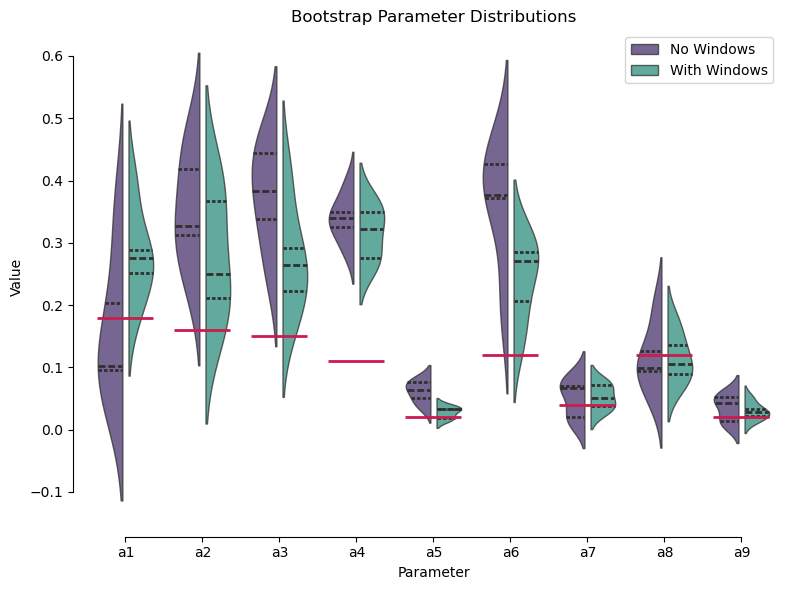

In [47]:
colors = [viridis_pal[0], viridis_pal[4]]

plt.figure(figsize=(8, 6), facecolor="white")

# Violin plot for bootstrap distributions
sns.violinplot(
    data=df_bootstrap_all,
    x="Parameter",
    y="Value",
    hue="Strategy",
    palette=colors,
    alpha=0.75,
    linewidth=1.0,
    density_norm="count",  # same as your old code
    split=True,
    gap=0.2,
    inner="quart",  # show quartiles
    inner_kws=dict(linewidth=2)
)

# Ground truth as a horizontal marker for each parameter
sns.pointplot(
    data=df_ground,
    x="Parameter",
    y="Value",
    color=rocket_pal[1],   # ground truth marker color
    linestyle="none",
    marker="_",
    markersize=40,
    markeredgewidth=2
)

sns.despine(offset=10, trim=True)

plt.title("Bootstrap Parameter Distributions")
plt.tight_layout()

plt.show()

---
**END OF THE CODE**